# IIC3724-1: Reconocimiento de Patrones
# Tarea 1: Reconocimiento de caracteres
## Agustín Urrutia
Fecha de entrega: 3 de abril

Se usó como inspiración para la creación de algunas funciones el código utilizado por el profesor en la clase 3 ([link al colab](https://colab.research.google.com/drive/19pHFZFgxVVbKChlekecGvvmD7O9Dcscy?authuser=1#scrollTo=syLyWjv8d1B0)).

Se adjunta en el pdf del informe, pero de todos modos, [este enlace al árbol de decisión](https://drive.google.com/file/d/14ILXpnm4NzFqOQr1--i2DmmHKRpwAIZR/view?usp=sharing) que se utilizó para detectar los dígitos

In [2]:
import time
inicio = time.time()

## Librerías utilizadas

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from   scipy.ndimage import binary_fill_holes
import seaborn as sns
import cv2
import time
from prettytable import PrettyTable

## Carga de imágenes

In [4]:
# Descarga de todas las imágenes 
!wget https://www.dropbox.com/s/qix65nxcevypw0a/T01_imagenes.zip
!unzip T01_imagenes.zip
print("Done")

--2023-05-16 15:38:34--  https://www.dropbox.com/s/qix65nxcevypw0a/T01_imagenes.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/qix65nxcevypw0a/T01_imagenes.zip [following]
--2023-05-16 15:38:34--  https://www.dropbox.com/s/raw/qix65nxcevypw0a/T01_imagenes.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5283bb2bdc498d6e9a80decbd0.dl.dropboxusercontent.com/cd/0/inline/B8LAZzp1EeFnF2lkBc7tpTrOe-0t4k4tC14dYgPGHhHYWYSUw5r8CgBzooSSi08Lmnx7bg949o3WfHNnjrgPy338dkJPISuTPyMFyghhvfPMVV4F-wY-PBt9-4971ZkHc7_nhjuZn824UX_8T2dkyU4EjVedCnEaP0ItTlKlg3yhyg/file# [following]
--2023-05-16 15:38:34--  https://uc5283bb2bdc498d6e9a80decbd0.dl.dropboxusercontent.com/cd/0/inline/B8LAZzp1EeFnF2lkBc7tpTrOe-0t4k4tC14dYgPGHhHYWYSUw5r8CgBzooSSi08Lmnx7

## Declaración de funciones
* Carga de imágenes
* Enfoque de imágenes y separación de valores, para trabajar solo con los dígitos y no con la completitud del png
* Normalización del área


In [5]:
def LoadImage(prefix, number, echo=False, long=2):
  '''
  Primero ajustamos el str para que obtenga la dirección de la imagen deseada,
  luego, leemos la imagen y retornamos lo obtenido
  '''
  number_format = str(number).zfill(long)
  dir = prefix + "_" + number_format + ".png"
  
  if echo:
    print(f'Cargando imagen {dir}...')
  
  img = plt.imread(dir)
  gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  pixel_img = (gray_img > 0.5).astype(int)
  return pixel_img


In [6]:
##################################
### Functions to cut the image ###
##################################

RANGE = lambda top, reverse: range(top) if not reverse else range(top - 1, -1, -1)

def cut_sides(img, reverse=False):
  height = len(img)
  width = len(img[0])

  for i in RANGE(width, reverse):
    for j in RANGE(height, False):
      if img[j][i].any() != 0:
        return i

  return -1

def cut_top_down(img, reverse=False):
  height = len(img)
  width = len(img[0])

  for i in RANGE(height, reverse):
    for j in RANGE(width, False):
      if img[i][j].any() != 0:
        return i
  
  return -1

def horizontal_cut(img, left, right):
  
  out = []
  for x in img:
    out.append( x[left : right + 1])
  
  return out

def focus(img):
  filas, columnas = np.where(img == 1)

  t = np.min(filas)
  b = np.max(filas)
  l = np.min(columnas)
  r = np.max(columnas)

  new_img = img[t : b + 1]
  out = horizontal_cut(new_img, l - 1, r + 1)

  return np.array(out)

In [7]:
##################################################
### Function to split numbers of focused image ###
##################################################

# input: img focused
# output: digits of the number splited in an array
def split_digits(img):
  # Parámetros
  W = len(img[0])
  H = len(img)

  # Salida
  numbers = []

  scanning_number = False
  start = -1
  end   = -1

  # De izquierda a derecha, vamos viendo si encontramos pixeles verticalmente
  for w in range(W):
    for h in range(H):
      if img[h][w].any() != 0:
        
        if not scanning_number:
          start = w
          scanning_number = True

        end = w
        break
    
    if scanning_number and end != w:
      single_number = []
      for x in img:
        single_number.append(x[start :end + 1])
      
      numbers.append(np.array(single_number))
      scanning_number = False

  return numbers
      

In [8]:
# Función extraida de PAT01_Separacion_JQ.ipynb
def AreaNormalizada(img, echo=False):
  R = img>0.5                          
  R = binary_fill_holes(R).astype(int) 
  CharArea = np.sum(R)                 
  ImgArea  = R.shape[0]*R.shape[1]    
  AreaN = CharArea/ImgArea            
  if echo:
    implot = plt.imshow(R,cmap='gray') 
    print('Area normalizada = '+str(AreaN))
  return AreaN, R

## Ejemplo de que funciona todo correctamente

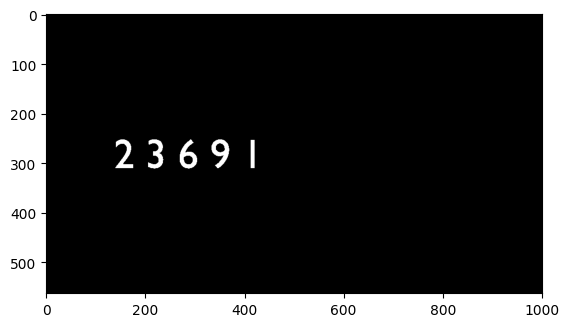

In [9]:
# Ejemplo de cargar imagen
fig = plt.figure()
ax  = fig.add_subplot(111)
img = LoadImage("prueba", 5)
implot = plt.imshow(img, cmap="gray")

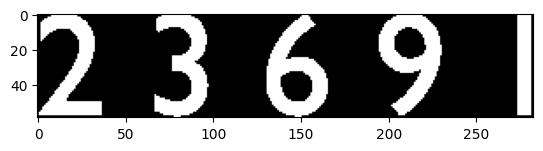

In [10]:
# Ejemplo enfocar imagen
new_img = focus(img)
implot = plt.imshow(new_img, cmap="gray")

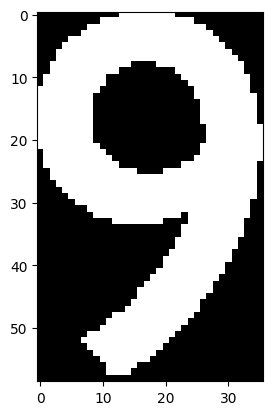

In [11]:
# Ejemplo obtener dígitos
array = split_digits(new_img)
implot = plt.imshow(array[3], cmap="gray")

Area normalizada = 0.596045197740113


0.596045197740113

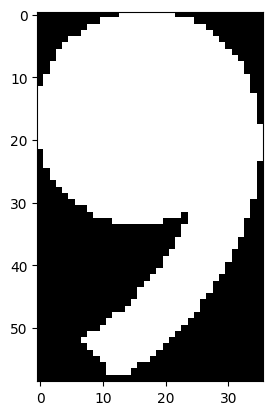

In [12]:
AreaNormalizada(array[3], True)[0]

## Obtener todas las imágenes y dejarlas en el formato adecuado para trabajarlas con mayor facilidad

`data` es una lista de listas, en la que cada lista contiene los dígitos del número de manera independiente

In [13]:
###############################################
### Extraer todos los números y sus dígitos ###
###############################################

t = time.time()
data = []
for i in range(20):
  img = LoadImage("prueba", i+1)
  img = (img > 0.5).astype(int)
  focused = focus(img)
  digits = split_digits(focused)
  data.append(digits)
  print(f'Tiempo de {i+1}: {time.time() - t}')


Tiempo de 1: 0.024276018142700195
Tiempo de 2: 0.043209075927734375
Tiempo de 3: 0.06770014762878418
Tiempo de 4: 0.11005187034606934
Tiempo de 5: 0.1635432243347168
Tiempo de 6: 0.18138623237609863
Tiempo de 7: 0.1997849941253662
Tiempo de 8: 0.22578811645507812
Tiempo de 9: 0.2691969871520996
Tiempo de 10: 0.3284947872161865
Tiempo de 11: 0.35587120056152344
Tiempo de 12: 0.3773813247680664
Tiempo de 13: 0.4079728126525879
Tiempo de 14: 0.46959710121154785
Tiempo de 15: 0.5583252906799316
Tiempo de 16: 0.5767967700958252
Tiempo de 17: 0.6011965274810791
Tiempo de 18: 0.638967752456665
Tiempo de 19: 0.6765027046203613
Tiempo de 20: 0.7713181972503662


In [14]:
# Números reales por imagen (en orde, siendo el i-ésimo, la imagen i+1)
numbers = [
 461129,
 9529,
 45190,
 628093,
 23691,
 4287239,
 86329,
 351908,
 7287093,
 282529,
 29112,
 2995,
 519045,
 808093628,
 23691623,
 87239,
 6863298,
 535190819,
 28709,
 28252925
]

In [15]:
answers = {}
for i, (real_n, img_n) in enumerate(zip(numbers, data)):
  answers[i] = {
      "img": img_n,
      "value": real_n
  }


## Funciones para identificar dígitos
Aquí están las funciones que permiten hacer la identificación de las imágenes. La principal es `filter`, la cual mediante reconocimiento de parámetros de los dígitos entregados retorna el número como un string

Se explica antes fe `filter` cómo se abordó el problema

Funciones con tentativa de ser útiles para filtrar datos

In [16]:
# Input: dígito de imagen
# Output: Imagen recortada por la mitad horizontalmente. Detalle: ambas partes 
#  tendrán el mismo tamaño, para evitar desequilibrio en pesos de pixeles y 
#  poder hacer resta de matrices
def horizontal_division(digit):
  H = int( len(digit) / 2 )

  top  = digit[ : H ]
  down = digit[ - H - 1 : -1 ]

  return np.array(top), np.array(down)


# Funcion que finalmente no fue usada, pero cortaba en tamaños iguales una 
#  imagen dejando un lado izquierdo y derecho  
def vertical_division(digit):
  W_l = int( len(digit[0]) / 2 )
  W_r = W_l - 1 + (W_l % 2)

  left = []
  right = []

  for row in digit:
    left.append(row[: W_l])
    right.append(row[W_r : -1])

  return np.array(left), np.array(right)


# Input: imagen de un dígito 
# Output: bool que indica si tiene o no agujero
# Funcionamiento: compara cantidad de pixeles pre y post llenado
def have_hole(digit):
  digit = digit > 0.5
  initial_area = np.sum(digit.astype(int))

  R = binary_fill_holes(digit).astype(int)
  final_area = np.sum(R)

  return initial_area != final_area

def get_area(digit):
  digit = digit > 0.5
  return np.sum(digit.astype(int))

# Dado que el marco en el que se encuentra el número, es proporcional al mismo 
#  número y no esuniforme entre todos ellos, se medirá que tantos pixeles hay 
#  proporcional a la altura del número
def normalized_area(digit):
  area = get_area(digit)
  H = len(digit)

  return area / H ** 2


Explicación de las decisiones: 
* En primer lugar, comparamos los números que tienen o no un agujero en él. Estos son: {0, 4, 6, 8, 9}
* De estos, está la opción que al dividirlos horizontalmente tengan el agujero arriba de esta mitad, abajo de ella, en ambas partes, o que la línea divisora corte al agujero. Estos criterios nos permiten identificar al 6, 8 y 9, pero queda por identificar al 4 y 0, ya que ambos caen en el último criterio explicado (la línea divisora corte al agujero)
* Para la división del 4 y 0, se observó que la cantidad de pixeles en el 0, al ser rellenado, es considerablemente mayor que la del 4 (resultado se adjuntará al final del `ipynb` en una sección llamada `Anexo de estudios`.
* Luego, comparamos los números que no tienen agujeros
* En primer lugar, podemos ver que el 7 está "desbalanceado" en sus pixeles de arriba vs abajo, teniendo más pixeles arriba, logrando diferenciarse así del resto de los números sin agujero. En el anexo de más abajo se determinó que el valor que separa al 7 del resto de los valores es 0.114
* Luego, para el 1, es posible ver que prácticamente usa todo el espacio del marco en el que fue recortado con anterioridad. Por eso, para detectarlo, se utilizó ver la proporción del área ocupada por él en el rectangulo que lo contiene. Tomando el promedio de los no 1 y promediando este valor con el del 1, se llegó al valor 0.71. el estudio se encuentra en el anexo
* Luego, se identificó que el 3 era muy similar su mitad superior vs la inferior en comparación con el 2 y el 5, que al ser reflejados y aplicar un XOR a la imagen se obtienen muchos pixeles de diferencia. Luego se aplicó la media a la proporción obtenida en el 2 y 5 y se promedió con lo obtenido con el 3. En el anexo se incluye una visualización más clara de a qué me refiero con el XOR y de cómo se obtuvo el parámetro.
* Finalmente, similar al caso anterior, se pudo ver que al rotar (no reflejar como en el caso anterior) y aplicar el XOR, el 5 queda con muy pocos pixeles, a diferencia del 2. Se calculó el promedio de el parámetro divisor en el anexo
* Solo queda el numero 2 a esta altura, el cual si se llega al final de las comparaciones se asume que es éste.

In [17]:
def filter(digits_array, echo=False):

  mean_0_4 = 0.575
  delta_top_down_seven = 0.114
  normalized_1 = 0.71
  delta_simetry_reflection = 0.31
  delta_simetry_rotation = 0.39

  output = ""

  for i, x in enumerate(digits_array):
    top, down = horizontal_division(x)

    if have_hole(x):
      top_hole = have_hole(top)
      down_hole = have_hole(down)

      if top_hole and down_hole:
        output += "8"
        continue

      if top_hole and not down_hole:
        output += "9"
        continue
      
      if not top_hole and down_hole:
        output += "6"
        continue
    
      if AreaNormalizada(x)[0] < mean_0_4:
        output += "4"
        continue
      
      output += "0"
      continue
    
    if normalized_area(top) - normalized_area(down) > delta_top_down_seven:
      output += "7"
      continue

    if AreaNormalizada(x)[0] > normalized_1:
      output += "1"
      continue    

    top_reflected = np.flip(top, 0)
    dif_matrix = abs(top_reflected - down)

    if normalized_area(dif_matrix) < delta_simetry_reflection:
      output += "3"
      continue

    top_rotated = np.flip(top)
    dif_matrix = abs(top_rotated - down)
    
    if normalized_area(dif_matrix) < delta_simetry_rotation:
      output += "5"
      continue

    output += "2"

      
  # print(output)
  return output

## Testeo
Se realiza la matriz de confusión y se calcula su tasa de éxito

In [18]:
confusion_matrix = np.zeros((10, 10))

for i in range(20):
  number_detected = filter(answers[i]["img"])
  real_number = str(answers[i]["value"])

  for j in range(len(real_number)):

    confusion_matrix[ int( real_number[j] ) ][ int( number_detected[j] ) ] += 1

table_data = [ [f"Real: {i}", *confusion_matrix[i] ] for i in range(10) ]
table = PrettyTable()
table.field_names = [" "] + [ f"Detected {i}" for i in range(10)]  
for row in table_data:
    table.add_row(row)
    table.add_row(['-' * 10] * 11)

table.del_row(-1)
print(table)

+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|            | Detected 0 | Detected 1 | Detected 2 | Detected 3 | Detected 4 | Detected 5 | Detected 6 | Detected 7 | Detected 8 | Detected 9 |
+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|  Real: 0   |    9.0     |    0.0     |    0.0     |    0.0     |    0.0     |    0.0     |    0.0     |    0.0     |    0.0     |    0.0     |
| ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- |
|  Real: 1   |    0.0     |    11.0    |    0.0     |    0.0     |    0.0     |    0.0     |    0.0     |    0.0     |    0.0     |    0.0     |
| ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- 

In [19]:
correct = 0
total = 0

for i in range(10):
  for j in range(10):
    total += confusion_matrix[i][j]
    if i == j:
      correct += confusion_matrix[i][j]
      continue

print(f"Éxito: {correct / total * 100}%")
    

Éxito: 100.0%


## Anexo de estudios

### Mostrar cómo se imprimen todos los dígitos

In [20]:
ref_img = plt.imread("referencia.png")
ref_img = cv2.cvtColor(ref_img,cv2.COLOR_BGR2GRAY)
ref_img = (ref_img > 0.5).astype(int)
focused = focus(ref_img)
digits = split_digits(focused)

0.8056978233034571
0.971830985915493
0.4113316261203585
0.4796345641416064
0.4129457596643692
0.46830985915492956
0.5922043891254504
0.3392801251956182
0.8085787451984635
0.5925319358008516


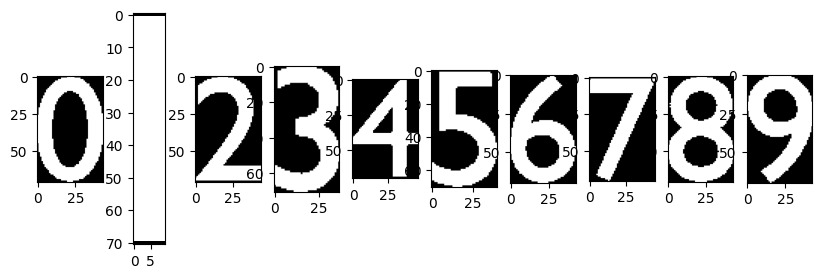

In [21]:
f, y = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
  y[i].imshow(digits[i], cmap="gray")
  print(AreaNormalizada(digits[i])[0])
  

### Diferenciar al 0 del 4
Factor que diferencia la proporción de área entre el 4 y el 0

In [22]:
ref_img = plt.imread("referencia.png")
ref_img = cv2.cvtColor(ref_img,cv2.COLOR_BGR2GRAY)
focused = focus(ref_img)
digits = split_digits(focused)

In [23]:
# Comparación del 4 y el 0
zero = digits[0]
four = digits[4]

area_0 = AreaNormalizada(zero)[0]
area_4 = AreaNormalizada(four)[0]

mean = ( area_0 + area_4 ) / 2
print(mean)

0.5982793873693144


Este resultado nos permitirá utilizar el número truncado (0.555) como criterio para diferenciar al 0 del 4. Cuando sea mayor, es el 0, de lo contrario es el 4

### Peso del 7
Encontraremos el factor que diferencia a los números con mayor peso arriba vs abajo

In [24]:
ref_img = plt.imread("referencia.png")
ref_img = cv2.cvtColor(ref_img,cv2.COLOR_BGR2GRAY)
focused = focus(ref_img)
digits = split_digits(focused)

In [25]:
for x in [1, 2, 3, 5, 7]:
  top, down = horizontal_division(digits[x])
  print(normalized_area(top) - normalized_area(down))

0.0
-0.05536332179930792
-0.037197231833910105
0.006055363321799345
0.28287197231833916


In [26]:
delta_peso = np.mean( [np.mean([-0.008163265306122436, -0.08244897959183672, -0.0424489795918368, 
                               -0.008163265306122436]), 0.2636734693877551] )

In [27]:
delta_peso

0.11418367346938775

Por lo que se usará este valor para diferenciar los números que están más balanceados hacia ser un 7 debido a su "peso" en la parte alta de la imagen vs la parte baja

### Área ocupada por el 1
Proporción de pixeles que observamos en el número 1 dado el espacio del marco que lo contiene

In [28]:
ref_img = plt.imread("referencia.png")
ref_img = cv2.cvtColor(ref_img,cv2.COLOR_BGR2GRAY)
ref_img = (ref_img > 0.5).astype(int)
focused = focus(ref_img)
digits = split_digits(focused)

In [29]:
n_1 = 0
n_not_1 = []

for i in [1, 2, 3, 5]:
  print(AreaNormalizada(digits[i])[0])
  if i == 1:
    n_1 = AreaNormalizada(digits[i])[0]
    continue
  n_not_1.append(AreaNormalizada(digits[i])[0])



0.971830985915493
0.4113316261203585
0.4796345641416064
0.46830985915492956


In [30]:
np.mean( [np.mean(n_not_1), n_1] )

0.7124615011938956

Por lo que usaremos este valor como el divisor para identificar al 1 del 2, 3 y 5

### Comparación entre números casi simetricos verticalmente

Mediante el siguiente estudio, se pudo ver que la mitad superior del 3 comparada con su mitad inferior, al ser reflejada, es muy parecida. No así con los números 2 y 5, los cuales mantienen una gran diferencia. 

0.5330612244897959
0.08816326530612245
0.5404081632653062


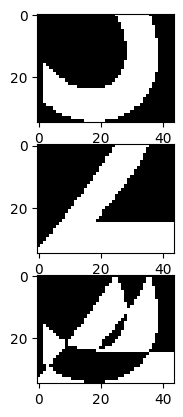

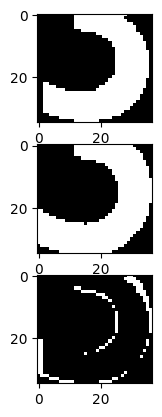

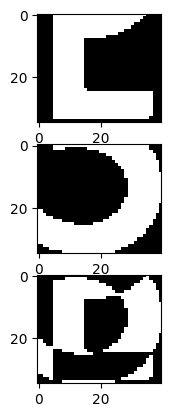

In [31]:
for i in [2, 3, 5]:
  u, d = horizontal_division(digits[i])

  u_prime = np.flip(u, 0)
  dif = abs(u_prime - d)
  print(np.sum(normalized_area(dif)))

  f, y = plt.subplots(3,1)
  y[0].imshow(u_prime, cmap="gray")
  y[1].imshow(d, cmap="gray")
  y[2].imshow(dif, cmap="gray")


In [32]:
n2 = 0.5330612244897959
n3 = 0.08816326530612245
n5 = 0.5404081632653062
dif = np.mean( [np.mean([n2, n5]), n3] )
dif

0.3124489795918367

De este estudio, se tomará como parámetro que, en el conjunto de aquellos 3 números, cuando se realice ese proceso, los casos en que el porcentaje de área diferente sea menor a 0.2, será considerado como el número 3, mientras que los otros dos casos (que en el estdio dio similar a 0.5) serán tomados como 2 o 5.

### Comparación entre números similares parte superior vs inferior al ser rotados
Con este método diferenciamos al 2 del 5

0.529795918367347
0.25795918367346937


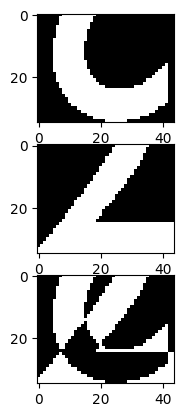

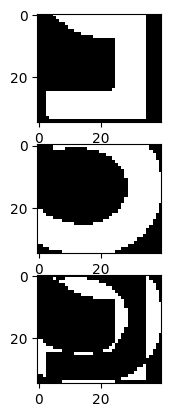

In [33]:
diff = {}
for i in [2, 5]:
  u, d = horizontal_division(digits[i])

  u_prime = np.flip(u)
  dif = abs(u_prime - d)
  diff[i] = np.sum(normalized_area(dif))
  print(diff[i])

  f, y = plt.subplots(3,1)
  y[0].imshow(u_prime, cmap="gray")
  y[1].imshow(d, cmap="gray")
  y[2].imshow(dif, cmap="gray")


A diferencia del caso anterior, en vez de reflejar verticalmente, en este caso se rotó la parte superior en 180° y luego se realizó la diferencia. De aquí se pudo ver que el 2 "cancela" muy pocos pixeles (esta operación es similar a un XOR). Por lo que se utilizará el promedio de ambos valores para tomar como parámetro de diferencia.

In [34]:
(diff[2] + diff[5]) / 2

0.39387755102040817

## Formato de entrega

In [35]:
def Reconocedor(img):
  # Sanity check to work with 1 or 0
  img = (img > 0.5).astype(int)

  # Get just the part of the img that we will study
  focused = focus(img)

  # Split digits
  digits = split_digits(focused)

  detected_number = list(filter(digits))
  # print(detected_number)
  return detected_number


In [36]:
t0 = time.time()
Reconocedor(LoadImage("prueba", 1))
print(time.time() - t0)

0.034017324447631836


In [37]:
print(f'Tiempo final: {time.time() - inicio}')

Tiempo final: 10.588397026062012
